In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

import pandas as pd

1 Physical GPUs, 1 Logical GPUs


In [2]:
from pde_solvers.cn import *
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

# Load the parameters

In [3]:
df = pd.read_csv("../df_network_analysis.csv")
df["adj_tup"] = df["adj_tup"].apply(lambda x: eval(f"tuple({x})"))
df["Adj"] = df["adj_tup"].apply(lambda x: np.array(x).reshape((3,3)))

In [4]:
adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [5]:
with open('../turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('../outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [6]:
subnet_df.head(1)

,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,std_A,...,lb_CB,ub_CB,state_CC,lb_CC,ub_CC,Adj,k_max,params,path,adj_tup
116,0.879311,27.4671,2.00005,3.859942,31.707845,2.000238,6.759598,35.970982,2.000543,1.49011,...,1.780018,56.210562,Active,0.880009,28.110281,"[[1, 1, -1], [-1, 0, -1], [0, -1, 1]]",8.430177,[4.0e+00 1.0e-03 1.0e-01 5.0e+00 5.0e+00 5.0e+...,outputs_second_search/solution_10_0_24.npy,"(1, 1, -1, -1, 0, -1, 0, -1, 1)"


In [7]:
def load_dataset(path):
    with open(f"../{path}", "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [50]:
def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)

def simulation(index, epochs=20000+1, epochs2=20000+1, epochs3=20000+1, scale=None, run="1"):
    print("######################################################")
    path = subnet_df["path"].iloc[index]
    print(index, path)
    (params, res, k_max) = load_dataset(path)
    plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
    
    T=1    
    L=10
    data = reshape(res, T)
    nodes_n = data.shape[0]
    node_names = ["A", "B", "C"]
    x_size = data.shape[1]
    y_size = data.shape[2]
    ##########################################
    # Create a mesh that is the centers of the
    # original mesh
    x_size -= 1
    y_size -= 1
    dxdy = L**2/((x_size-1)*(y_size-1))
    #####
    N = x_size*y_size    
    t_star = np.arange(T, T+1)

    ##########################
    # select a subset of data
    #t_star = t_star[-4:]
    #T = len(t_star)
    #data = data[:, :, :, -4::]


    x_slice = slice(65, 100, 1)
    y_slice = slice(65, 100, 1)


    x_range = L * np.linspace(0, 1, x_size)[x_slice]
    y_range = L * np.linspace(0, 1, y_size)[y_slice]

    block_x = x_range.shape[0]
    block_y = y_range.shape[0]

    x = tf.constant(x_range, dtype=tf.float32)
    y = tf.constant(y_range, dtype=tf.float32)


    # The order of the Y and X must be reversed,
    # since the chnages the value finds the derivatives
    #Y, X = tf.meshgrid(x, y)

    X, Y = tf.meshgrid(x, y)
    ts = tf.constant(t_star, dtype=tf.float32)
    T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
    def H_cube(X, Y, T):
        return tf.concat(
                [
                    tf.concat(
                        [
                            X[tf.newaxis, :, :, tf.newaxis],
                            Y[tf.newaxis, :, :, tf.newaxis],
                            T[:, :, i : i + 1][tf.newaxis, :, :, :],
                        ],
                        axis=3,
                    )
                    for i in range(T.shape[-1])
                ],
                axis=0,
            )
    H = H_cube(X, Y, T)    
    ########################################
    # Take the average of data points
    kernel =np.array([[1, 1],
                      [1, 1]])


    data2 = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)[x_slice, y_slice] 
                            for j in  range(data.shape[3])]
                            for i in  range(data.shape[0])])
    data2 = np.einsum("ctxy -> cxyt", data2)

    ############################################ 
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data[i, x_slice, y_slice, -1])
        plt.colorbar()
    plt.tight_layout();plt.show()
    
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data2[i, :, :, -1])
        plt.colorbar()
    plt.tight_layout();plt.show()
    
    ############################################
    c_xx_out =  np.array([[second_order_derivatives((128, 128), data[c, ..., t])[0]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
    c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
    c_yy_out = np.array([[second_order_derivatives((128, 128), data[c, ..., t])[1]
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy_out = np.einsum("ctij -> cijt", c_yy_out)

    A_finit_diff_der = ( c_xx_out[0,:, :  , -1] + c_yy_out[0,:, :  , -1])[x_slice, y_slice]
    B_finit_diff_der = ( c_xx_out[1,:, :  , -1] + c_yy_out[1,:, :  , -1])[x_slice, y_slice]
    finit_diff = np.stack([A_finit_diff_der, B_finit_diff_der])[..., np.newaxis]
    finit_diff  = np.einsum( "cxyt -> txyc", finit_diff) 
    c = data2.copy()    
    c = np.einsum( "cxyt -> txyc", c) 
#     c_LoG = np.array([[ndimage.gaussian_laplace(c[i, :,:, j], sigma=.7)
#                      for i in range(c.shape[0])]
#                      for j in range(c.shape[3])
#                      ])
#     c_LoG = np.einsum( "ctxy -> txyc", c_LoG) 
#     print(c_LoG.shape)
    s2 = 2*np.sqrt(2)
    kernel2 =np.array([[1/s2, 1/4, 1/s2],
                       [1/4, -1 - 4/s2, 1/4],
                       [1/s2, 1/4, 1/s2]])
    c_kernel = np.array([[ndimage.convolve(c[i, :,:, j], kernel2)
                     for i in range(c.shape[0])]
                     for j in range(c.shape[3])
                     ])
    c_kernel = np.einsum( "ctxy -> txyc", c_kernel) 
    plot_n_im([finit_diff[-1,1:-1,1:-1,0], 
               c_kernel[-1,1:-1,1:-1,0], 
               finit_diff[-1,1:-1,1:-1,0]-c_kernel[-1,1:-1,1:-1,0]],
          ["A1", "A2", "differnce"],          
          figsize=(12, 6)); plt.tight_layout()
    plt.show()
    
    plot_n_im([finit_diff[-1, 1:-1,1:-1,1], 
               c_kernel[-1, 1:-1,1:-1,1], 
               finit_diff[-1, 1:-1,1:-1,1]-c_kernel[-1, 1:-1,1:-1,1]],
          ["B1", "B2", "differnce"],          
          figsize=(12, 6)); plt.tight_layout()
    plt.show()
    
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))

    H_flatten = flatten(H[:, 1:-1, 1:-1, :])
    c_flatten = flatten(c[:, 1:-1, 1:-1, :])
    c_kernel_flatten = flatten(c_kernel[:, 1:-1, 1:-1, :])

    def gen_series(H, c, c_kernel): 
        def gen():
            for i in range(H.shape[0]):
                yield H[i], c[i], c_kernel[i] 
        return gen    

     
    ds = tf.data.Dataset.from_generator(gen_series(H_flatten, c_flatten, c_kernel_flatten),
                                     output_types=(tf.float32, tf.float32, tf.float32), 
                                     output_shapes=((H_flatten.shape[1]),
                                                    (c_flatten.shape[1]),
                                                    (c_kernel_flatten.shape[1])))
    test_validation_ratio=0.8
    ds = ds.shuffle(H_flatten.shape[0], seed=42, reshuffle_each_iteration=False)
    ds_train = ds.take(int(H_flatten.shape[0]*test_validation_ratio))
    ds_validation = ds.skip(H_flatten.shape[0] - int(H_flatten.shape[0]*test_validation_ratio))
    ds_list_validation = np.array(list(ds_validation.as_numpy_iterator()))
    ############################################################
    def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 1e-8, 1e10,)
    
    def clip_by_D_lb(z):
        return tf.clip_by_value(z, 0.001, 1e10,)
    
    class tf_param:
        def __init__(self, name, value=None, is_constant=True):
            self.name = name
            if value is None:
                self.value = params[name]
            else:
                self.value = value
            self.is_constant = is_constant    


    def create_pinn(layers=[3, 1024, 1024, 3],
                    learning_rate=1e-2,
                    w1=1, w2=1, w3=1, w4=1, w5=1, w6=1, w7=1, w8=1,
                    D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                    b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                    V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                    mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                    K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                    K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                    K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                    n_val=tf_param("n")): 
        # Since there is just one time step, the lower bound is zero and the upper bound is one
        lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
        ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
        pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
        #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

        def create_tf_var(param, no_clip=False, D=False):
            print(f"{param.name}: {param.value}")
            if D:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name,
                                   constraint=clip_by_D_lb)
            if no_clip:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name)
            else:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name,
                                   constraint=clip_by_value_zero_lb)

        D_A = create_tf_var(D_A_val)    
        D_B = create_tf_var(D_B_val)
        b_A = create_tf_var(b_A_val)#
        b_B = create_tf_var(b_B_val)#
        b_C = create_tf_var(b_C_val)#
        V_A = create_tf_var(V_A_val)
        V_B = create_tf_var(V_B_val)
        V_C = create_tf_var(V_C_val)
        mu_A = create_tf_var(mu_A_val)
        mu_B = create_tf_var(mu_B_val)
        mu_C = create_tf_var(mu_C_val)
        K_AA = create_tf_var(K_AA_val)
        K_AB = create_tf_var(K_AB_val)
        K_AC = create_tf_var(K_AC_val)
        K_BA = create_tf_var(K_BA_val)
        K_BC = create_tf_var(K_BC_val)
        K_CB = create_tf_var(K_CB_val)
        K_CC = create_tf_var(K_CC_val)
        n = create_tf_var(n_val)

        w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
        w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
        w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
        w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
        w5 = tf.Variable(w4,dtype=pinn.dtype,name="w5")
        w6 = tf.Variable(w4,dtype=pinn.dtype,name="w6")   
        w7 = tf.Variable(w4,dtype=pinn.dtype,name="w7")
        w8 = tf.Variable(w4,dtype=pinn.dtype,name="w8")

        def as_tuple(val, param):
            if val.is_constant:
                return ()
            else:
                return (param,)


        params_trainable =(
                          as_tuple(D_A_val, D_A)
                        + as_tuple(D_B_val, D_B)
                        + as_tuple(b_A_val, b_A)
                        + as_tuple(b_B_val, b_B)
                        + as_tuple(b_C_val, b_C)
                        + as_tuple(V_A_val, V_A)
                        + as_tuple(V_B_val, V_B)
                        + as_tuple(V_C_val, V_C)
                        + as_tuple(mu_A_val, mu_A)
                        + as_tuple(mu_B_val, mu_B)
                        + as_tuple(mu_C_val, mu_C)                    
                        + as_tuple(K_AA_val, K_AA)
                        + as_tuple(K_AB_val, K_AB)
                        + as_tuple(K_AC_val, K_AC)
                        + as_tuple(K_BA_val, K_BA)
                        + as_tuple(K_BC_val, K_BC)
                        + as_tuple(K_CB_val, K_CB)
                        + as_tuple(K_CC_val, K_CC)
                       )
        

        @tf.function
        def train_step_inverse(elements):
            #def flatten(arr):
            #    return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))

            # Using VALID padding removes the boundaries
            #print(elements[1][..., 0:1].shape)
            #act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
            #print(act_A_laplacian.shape)
            #act_A_laplacian = flatten(act_A_laplacian)
            #print(act_A_laplacian.shape)
            #act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
            #act_B_laplacian = flatten(act_B_laplacian)

            #act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
            #act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))

            #act_A_laplacian = flatten(elements[2][..., 0:1][:, 1:-1, 1:-1, :])
            #act_B_laplacian = flatten(elements[2][..., 1:2][:, 1:-1, 1:-1, :])
            #act_A_laplacian = flatten(elements[2][..., 0:1][:, 1:-1, 1:-1, :])
            #act_B_laplacian = flatten(elements[2][..., 1:2][:, 1:-1, 1:-1, :])
            act_A_laplacian = elements[2][..., 0:1]
            act_B_laplacian = elements[2][..., 1:2]
            act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
            act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))


            with tf.GradientTape(persistent=True) as tape: 
                H = elements[0]
                # remove the boundaries
                #H = H[:, 1:-1, 1:-1, :]
                tape.watch(H)
                trainables = pinn.trainable_variables + params_trainable

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
                Cg = tf.squeeze(outputs[:, 2])

                grad_A = tape.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


                grad_A_x = tape.gradient(A_x, H)
                A_xx = grad_A_x[:, 0]
                grad_A_y = tape.gradient(A_y, H)
                A_yy = grad_A_y[:, 1]
                grad_B_x = tape.gradient(B_x, H)
                B_xx = grad_B_x[:, 0]
                grad_B_y = tape.gradient(B_y, H)
                B_yy = grad_B_y[:, 1]

                H2 = elements[1]
                A = tf.squeeze(H2[:, 0])
                B = tf.squeeze(H2[:, 1])
                C = tf.squeeze(H2[:, 2])                

                def act(x, km, n=4):
                    return 1 / (1 + (km / (x + 1e-20)) ** (n))

                def inh(x, km, n=4):
                    return 1 / (1 + (x / (km + 1e-20)) ** (n))

                A_rhs =  (A_xx + A_yy)# - u_t
                B_rhs =  (B_xx + B_yy)# - v_t


                
                f_A =  b_A + V_A*act(Ag, K_AA, n)*inh(Bg, K_BA, n) - mu_A * Ag + D_A * A_rhs
                f_B =  b_B + V_B*act(Ag, K_AB, n)*inh(Cg, K_CB, n) - mu_B * Bg + D_B * B_rhs
                f_C =  b_C + V_C*inh(Ag, K_AC, n)*inh(Bg, K_BC, n)*act(Cg, K_CC, n) - mu_C * Cg

                l2_res_A = tf.reduce_mean(f_A**2)
                l2_res_B = tf.reduce_mean(f_B**2)
                l2_res_C = tf.reduce_mean(f_C**2) 

                l2_res_A_rhs = tf.reduce_mean((A_rhs-act_A_rhs)**2)
                l2_res_B_rhs = tf.reduce_mean((B_rhs-act_B_rhs)**2)
                
                l2_A = tf.reduce_mean((A-Ag)**2)
                l2_B = tf.reduce_mean((B-Bg)**2)
                l2_C = tf.reduce_mean((C-Cg)**2)


                l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C +
                      w4*l2_res_A_rhs + w5*l2_res_B_rhs +
                      w6*l2_A + w7*l2_B+ w8*l2_C)

            grads = tape.gradient(l2, trainables)
            optimizer.apply_gradients(zip(grads, trainables))
            return (l2_res_A, l2_res_B, 
                    l2_res_C,  
                    l2_res_A_rhs, l2_res_B_rhs,
                    l2_A, l2_B, l2_C
            )

        names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
                 'l2_res_A_rhs', 'l2_res_B_rhs', 
                 'l2_A', 'l2_B', 'l2_C']

        def print_callback(printer, losses, epoch):

            printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
            printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
            printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))

        return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
                w1, w2, w3, w4, w5, w6, w7, w8)
    ############################################################
    if scale is None:
        (pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
            w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
            D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
            b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                              b_C_val=tf_param("b_C", 1, False),
            V_A_val=tf_param("V_A", 1, False),V_B_val=tf_param("V_B", 1, False),
                                              V_C_val=tf_param("V_C", 1, False),
            K_AA_val=tf_param("K_AA", 1, False),K_AB_val=tf_param("K_AB", 1, False),
            K_AC_val=tf_param("K_AC", 1, False), K_BA_val=tf_param("K_BA", 1, False),
            K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 1, False),
            K_CC_val=tf_param("K_CC", 1, False),       
            #mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
            w1=1, w2=1, w3=1, w4=1, w5=1, w6=1, w7=1, w8=1
            )
    else:
        (pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
            w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
            D_A_val=tf_param("D_A",params["D_A"]*scale , False), 
            D_B_val=tf_param("D_B",params["D_B"]*scale, False),
            b_A_val=tf_param("b_A",params["b_A"]*scale, False),
            b_B_val=tf_param("b_B",params["b_B"]*scale, False),
            b_C_val=tf_param("b_C",params["b_C"]*scale, False),
            V_A_val=tf_param("V_A",params["V_A"]*scale, False),
            V_B_val=tf_param("V_B",params["V_B"]*scale, False),
            V_C_val=tf_param("V_C",params["V_C"]*scale, False),
            K_AA_val=tf_param("K_AA",params["K_AA"]*scale, False),
            K_AB_val=tf_param("K_AB",params["K_AB"]*scale, False),
            K_AC_val=tf_param("K_AC",params["K_AC"]*scale, False), 
            K_BA_val=tf_param("K_BA",params["K_BA"]*scale, False),
            K_BC_val=tf_param("K_BC",params["K_BC"]*scale, False), 
            K_CB_val=tf_param("K_CB",params["K_CB"]*scale, False),
            K_CC_val=tf_param("K_CC",params["K_CC"]*scale, False),       
            #mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
            w1=1, w2=1, w3=1, w4=1, w5=1, w6=1, w7=1, w8=1
            )
    ############################################################ 
    def create_epoch_callback(validation_loss):
        def epoch_callback1(epoch, loss_samples, index):            
            outputs = pinn1.net(ds_list_validation[:, 0, :])
            Ag = outputs[:, 0]
            Bg = outputs[:, 1]
            Cg = outputs[:, 2]

            A = ds_list_validation[:, 1, :][:, 0]
            B = ds_list_validation[:, 1, :][:, 1]
            C = ds_list_validation[:, 1, :][:, 2] 
            l2_res_A = np.mean((A - Ag)**2)
            l2_res_B = np.mean((B - Bg)**2)
            l2_res_C = np.mean((C - Cg)**2)    

            validation_loss[epoch, : ] = (l2_res_A, l2_res_B, l2_res_C)
            if epoch%1000==0:
                print(f"observation loss: {loss_samples[index, -3]}, {loss_samples[index, -2]}, {loss_samples[index, -1]}")
                print(f"total observation loss: {np.sum(loss_samples[index, -3:])}")
                print(f"validation loss: {l2_res_A}, {l2_res_B}, {l2_res_C}")
                print(f"total validation loss: {l2_res_A + l2_res_B + l2_res_C}")
        return epoch_callback1
    
    params_est = np.zeros((epochs, len(params_trainable1)))
    params_est2 = np.zeros((epochs2, len(params_trainable1)))
    params_est3 = np.zeros((epochs3, len(params_trainable1)))
        
    validation_loss1 = np.zeros((epochs, 3))
    validation_loss2 = np.zeros((epochs2, 3))
    validation_loss3 = np.zeros((epochs3, 3))

    epoch_callback1 = create_epoch_callback(validation_loss1)
    epoch_callback2 = create_epoch_callback(validation_loss2)
    epoch_callback3 = create_epoch_callback(validation_loss3)
    ########################
    losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=2000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)
    optimizer1.lr.assign(1e-3)
    losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=2000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)
    optimizer1.lr.assign(1e-4)
    losses3 = tu.train(epochs=epochs3,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=2000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3,
                  stop_condition=None)
    print("--------------------------------------")
    print(params)
    print("--------------------------------------")
    plt.plot(np.concatenate([losses1, losses2, losses3]))
    plt.yscale('log')
    plt.grid();plt.show()
    plt.plot(np.sum(np.r_[losses1[:,-3:], losses2[:,-3:], losses3[:,-3:]],axis=1), label="Train loss")
    plt.plot(np.sum(np.r_[validation_loss1, validation_loss2, validation_loss3],axis=1), label="Validation loss")
    plt.legend();plt.yscale('log');plt.grid();plt.show()
    #############################################################
    (b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
     K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
     K_CB_val, K_CC_val ) = params_trainable1
    (n_val, D_A_val, D_B_val,
     b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
     K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
     K_CB_val, K_CC_val ) = (params["n"], params["D_A"], params["D_B"],
                             b_A_val, b_B_val, b_C_val,
                             V_A_val, V_B_val, V_C_val,
                             params["mu_A"], params["mu_B"], params["mu_C"],
                             K_AA_val, K_AB_val, K_AC_val, 
                             K_BA_val, K_BC_val, 
                             K_CB_val, K_CC_val)
    return ((L, n_val, D_A_val, D_B_val,
             b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
             K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
             K_CB_val, K_CC_val),
             np.concatenate([params_est, params_est2, params_est3]),
             pinn1,
             optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
             w1, w2, w3, w4, w5, w6, w7, w8,
             np.concatenate([losses1, losses2, losses3]),
             np.concatenate([validation_loss1, validation_loss2, validation_loss3]),
             ds_list_validation,
             ds_train)
    
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, (L, n_val, D_A_val, D_B_val,
#                 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
#                 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
#                 K_CB_val, K_CC_val))
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_history_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, np.concatenate([params_est, params_est2, params_est3]))
        
#     pinn1.save(".", f"../PINN_diffusion_outputs_second_search/full_subnets/pinn_{run}_{index}_no_diff")
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/losses_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, np.concatenate([losses1, losses2, losses3]))

    

In [ ]:
'b_A': 0.001, 'b_B': 0.1, 'b_C': 1.0, 'V_A': 20.0,  'V_B': 100.0, 
'V_C': 100.0, 'K_AA': 5.0, 'K_AB': 5.0, 'K_AC': 10.0, 
'K_BA': 10.0, 'K_BC': 5.0, 'K_CB': 10.0, 'K_CC': 10.0

######################################################
12 outputs_second_search/solution_10_10_103.npy


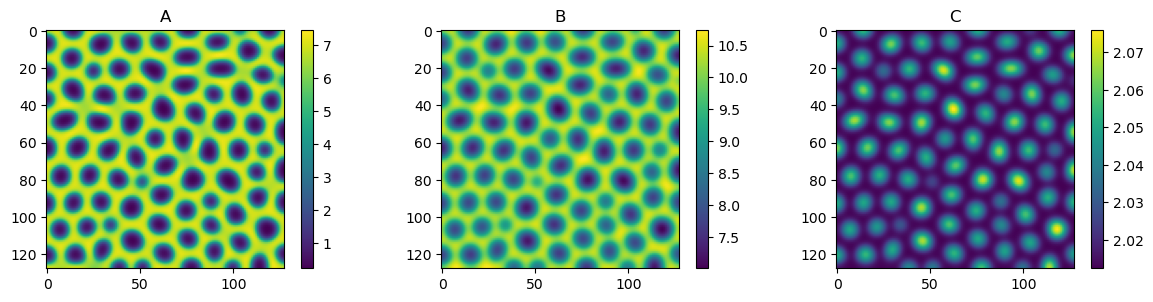

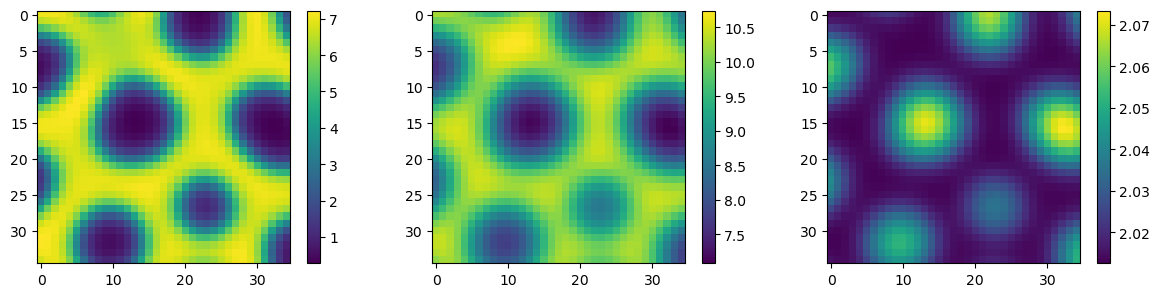

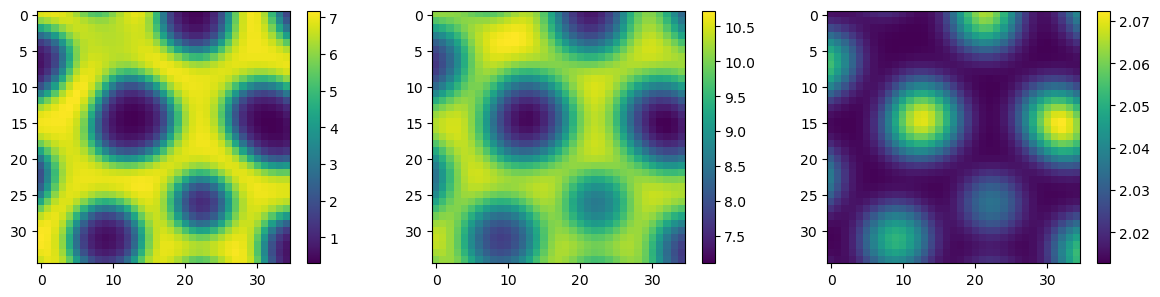

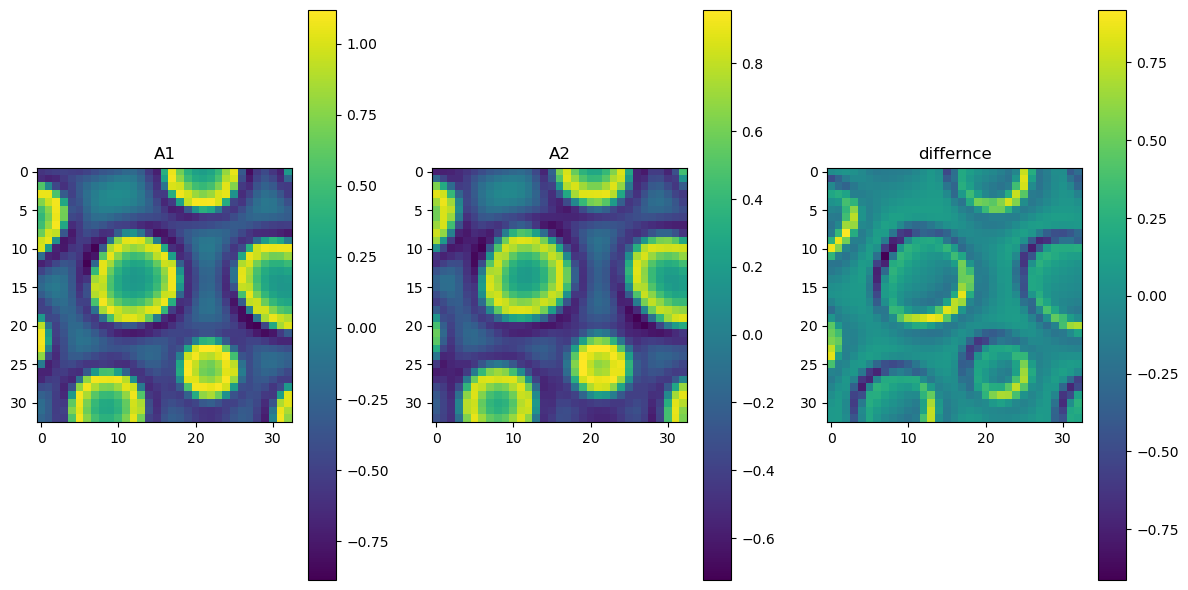

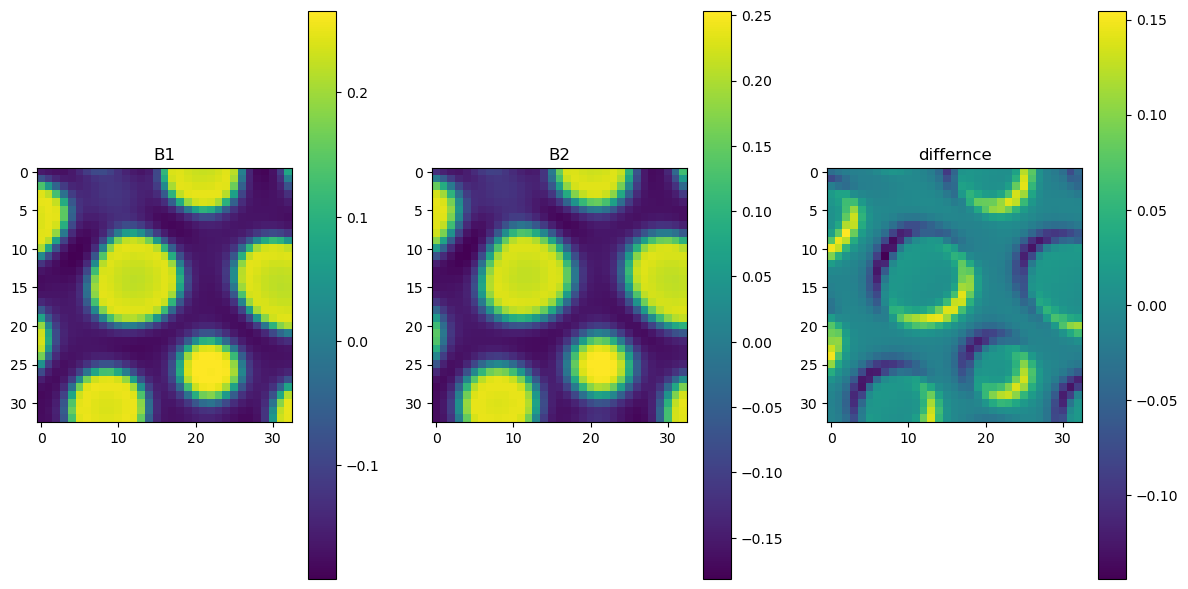

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
V_A: 1
V_B: 1
V_C: 1
mu_A: 1.0
mu_B: 5.0
mu_C: 0.5
K_AA: 1
K_AB: 1
K_AC: 1
K_BA: 1
K_BC: 1
K_CB: 1
K_CC: 1
n: 4.0

Start of epoch 0
observation loss: 28.565454483032227, 89.90861511230469, 4.322463512420654
total observation loss: 122.79653310775757
validation loss: 5.060873508453369, 3.763984203338623, 1.3302782773971558
total validation loss: 10.155136108398438
at epoch 0, total loss: 6668.424086511135
l2_res_A: 1.06755757, l2_res_B: 0.97215539, l2_res_C: 1.05457628, l2_res_A_rhs: 5932.74072266, l2_res_B_rhs: 609.79254150, l2_A: 28.56545448, l2_B: 89.90861511, l2_C: 4.32246351
b_A:0: 0.9899997711181641, b_B:0: 0.9899997711181641, b_C:0: 0.9899997711181641, V_A:0: 0.9909047484397888, V_B:0: 0.9908354878425598, V_C:0: 0.990578293800354, K_AA:0: 1.0097575187683105, K_AB:0: 1.009777307510376, K_AC:0: 0.9999979138374329, K_BA:0: 0.9999979138374329, K_BC:0: 0.999996542930603, K_CB:0: 0.9999980926513672, K_CC:0: 1.0098490715026855
Time taken: 10.25s
o

observation loss: 0.1506824642419815, 0.09871633350849152, 0.8667463064193726
total observation loss: 1.1161451041698456
validation loss: 0.15260064601898193, 0.09733063727617264, 0.8801485896110535
total validation loss: 1.1300798654556274

Start of epoch 16000
observation loss: 0.1051999032497406, 0.06406135857105255, 0.7784805297851562
total observation loss: 0.9477417916059494
validation loss: 0.11068616807460785, 0.06721235066652298, 0.78143310546875
total validation loss: 0.9593316316604614
at epoch 16000, total loss: 1.513178416644223
l2_res_A: 0.03513981, l2_res_B: 0.17102872, l2_res_C: 0.00185687, l2_res_A_rhs: 0.18756375, l2_res_B_rhs: 0.16984747, l2_A: 0.10519990, l2_B: 0.06406136, l2_C: 0.77848053
b_A:0: 0.1806955188512802, b_B:0: 5.496499061584473, b_C:0: 0.3900744616985321, V_A:0: 9.950952529907227, V_B:0: 75.48970031738281, V_C:0: 1.5290337800979614, K_AA:0: 4.4215545654296875, K_AB:0: 2.751495122909546, K_AC:0: 13.909996032714844, K_BA:0: 15.559425354003906, K_BC:0: 11.

observation loss: 0.03317635506391525, 0.008967659436166286, 0.45509102940559387
total observation loss: 0.4972350439056754
validation loss: 0.033156055957078934, 0.008881687186658382, 0.4636160433292389
total validation loss: 0.5056537985801697

Start of epoch 10000
observation loss: 0.032294489443302155, 0.008451888337731361, 0.4361005425453186
total observation loss: 0.4768469203263521
validation loss: 0.030649812892079353, 0.00821965467184782, 0.445861279964447
total validation loss: 0.4847307503223419
at epoch 10000, total loss: 0.5652467231848277
l2_res_A: 0.01292524, l2_res_B: 0.02092409, l2_res_C: 0.00051122, l2_res_A_rhs: 0.03168977, l2_res_B_rhs: 0.02234949, l2_A: 0.03229449, l2_B: 0.00845189, l2_C: 0.43610054
b_A:0: 0.25078335404396057, b_B:0: 3.2600088119506836, b_C:0: 0.49066755175590515, V_A:0: 13.7547607421875, V_B:0: 81.60263061523438, V_C:0: 1.219639778137207, K_AA:0: 4.775684356689453, K_AB:0: 3.25168776512146, K_AC:0: 24.348447799682617, K_BA:0: 11.719724655151367, K

observation loss: 0.022370895370841026, 0.005350982304662466, 0.26855993270874023
total observation loss: 0.2962818103842437
validation loss: 0.021259574219584465, 0.005308820400387049, 0.27538836002349854
total validation loss: 0.30195674300193787

Start of epoch 26000
observation loss: 0.021302049979567528, 0.005212979856878519, 0.26226088404655457
total observation loss: 0.2887759138830006
validation loss: 0.021296242251992226, 0.00523977680131793, 0.26776444911956787
total validation loss: 0.29430046677589417
at epoch 26000, total loss: 0.3518001743068453
l2_res_A: 0.01031934, l2_res_B: 0.02046400, l2_res_C: 0.00013167, l2_res_A_rhs: 0.01690072, l2_res_B_rhs: 0.01520853, l2_A: 0.02130205, l2_B: 0.00521298, l2_C: 0.26226088
b_A:0: 0.2680528461933136, b_B:0: 2.9856579303741455, b_C:0: 0.5434337854385376, V_A:0: 15.154114723205566, V_B:0: 85.70332336425781, V_C:0: 1.1832268238067627, K_AA:0: 4.87385892868042, K_AB:0: 3.597602128982544, K_AC:0: 33.494773864746094, K_BA:0: 11.1183433532

observation loss: 0.019501889124512672, 0.004331979434937239, 0.18754129111766815
total observation loss: 0.21137515967711806
validation loss: 0.019107431173324585, 0.004313861485570669, 0.19126950204372406
total validation loss: 0.21469078958034515

Start of epoch 42000
observation loss: 0.018856357783079147, 0.004316830076277256, 0.1841670274734497
total observation loss: 0.2073402153328061
validation loss: 0.019646579399704933, 0.004289939999580383, 0.18688443303108215
total validation loss: 0.21082095801830292
at epoch 42000, total loss: 0.2690548568498343
l2_res_A: 0.00922644, l2_res_B: 0.03217722, l2_res_C: 0.00004736, l2_res_A_rhs: 0.00575743, l2_res_B_rhs: 0.01450619, l2_A: 0.01885636, l2_B: 0.00431683, l2_C: 0.18416703
b_A:0: 0.28076350688934326, b_B:0: 2.884056568145752, b_C:0: 0.5669336318969727, V_A:0: 15.67702579498291, V_B:0: 88.47463989257812, V_C:0: 1.1620290279388428, K_AA:0: 4.913719177246094, K_AB:0: 3.815402030944824, K_AC:0: 37.36597442626953, K_BA:0: 10.9368724822

observation loss: 0.017797106876969337, 0.0038309842348098755, 0.1513955444097519
total observation loss: 0.1730236355215311
validation loss: 0.017941422760486603, 0.003824932035058737, 0.15444299578666687
total validation loss: 0.17620934545993805

Start of epoch 6000
observation loss: 0.01768292672932148, 0.0038435347378253937, 0.14969132840633392
total observation loss: 0.1712177898734808
validation loss: 0.017774028703570366, 0.0038436935283243656, 0.1527175009250641
total validation loss: 0.17433522641658783
at epoch 6000, total loss: 0.2076754576210078
l2_res_A: 0.00895726, l2_res_B: 0.01377575, l2_res_C: 0.00002520, l2_res_A_rhs: 0.00086864, l2_res_B_rhs: 0.01283082, l2_A: 0.01768293, l2_B: 0.00384353, l2_C: 0.14969133
b_A:0: 0.2844836115837097, b_B:0: 2.840566396713257, b_C:0: 0.5755460858345032, V_A:0: 15.840033531188965, V_B:0: 89.89089965820312, V_C:0: 1.1489518880844116, K_AA:0: 4.928889751434326, K_AB:0: 3.928366184234619, K_AC:0: 38.358856201171875, K_BA:0: 10.88770580291

observation loss: 0.016873246058821678, 0.0035984001588076353, 0.12785306572914124
total observation loss: 0.14832471194677055
validation loss: 0.017001019790768623, 0.0035880052018910646, 0.13043472170829773
total validation loss: 0.1510237455368042

Start of epoch 22000
observation loss: 0.016916008666157722, 0.0036099422723054886, 0.1265997737646103
total observation loss: 0.1471257247030735
validation loss: 0.01704232580959797, 0.003600795054808259, 0.12914176285266876
total validation loss: 0.1497848778963089
at epoch 22000, total loss: 0.18234605097131862
l2_res_A: 0.00882033, l2_res_B: 0.01298984, l2_res_C: 0.00001586, l2_res_A_rhs: 0.00099249, l2_res_B_rhs: 0.01240181, l2_A: 0.01691601, l2_B: 0.00360994, l2_C: 0.12659977
b_A:0: 0.2861635386943817, b_B:0: 2.817821979522705, b_C:0: 0.5816190838813782, V_A:0: 15.88535213470459, V_B:0: 90.88461303710938, V_C:0: 1.1407034397125244, K_AA:0: 4.935539245605469, K_AB:0: 4.018558025360107, K_AC:0: 38.480926513671875, K_BA:0: 10.877581596

observation loss: 0.0161362923681736, 0.003357079578563571, 0.10861890017986298
total observation loss: 0.12811227212660015
validation loss: 0.016237709671258926, 0.00333814206533134, 0.11087606102228165
total validation loss: 0.13045191764831543

Start of epoch 38000
observation loss: 0.01614212431013584, 0.0033775828778743744, 0.10762327909469604
total observation loss: 0.12714298628270626
validation loss: 0.016348421573638916, 0.0033732724841684103, 0.10976208746433258
total validation loss: 0.12948378920555115
at epoch 38000, total loss: 0.16168571767775575
l2_res_A: 0.00866468, l2_res_B: 0.01247776, l2_res_C: 0.00001047, l2_res_A_rhs: 0.00162004, l2_res_B_rhs: 0.01176979, l2_A: 0.01614212, l2_B: 0.00337758, l2_C: 0.10762328
b_A:0: 0.28850647807121277, b_B:0: 2.7950854301452637, b_C:0: 0.5873008370399475, V_A:0: 15.882562637329102, V_B:0: 91.79764556884766, V_C:0: 1.135738492012024, K_AA:0: 4.94012451171875, K_AB:0: 4.096278667449951, K_AC:0: 38.596717834472656, K_BA:0: 10.88342189

observation loss: 0.015093919821083546, 0.0031325730960816145, 0.09329769760370255
total observation loss: 0.1115241905208677
validation loss: 0.015229874290525913, 0.0031266689766198397, 0.09518900513648987
total validation loss: 0.11354555189609528

Start of epoch 54000
observation loss: 0.015032325871288776, 0.0031052231788635254, 0.09243212640285492
total observation loss: 0.11056967545300722
validation loss: 0.015202919952571392, 0.003094475017860532, 0.09425966441631317
total validation loss: 0.1125570610165596
at epoch 54000, total loss: 0.14867082655018748
l2_res_A: 0.00871143, l2_res_B: 0.01230711, l2_res_C: 0.00000716, l2_res_A_rhs: 0.00544098, l2_res_B_rhs: 0.01163447, l2_A: 0.01503233, l2_B: 0.00310522, l2_C: 0.09243213
b_A:0: 0.28943488001823425, b_B:0: 2.7756872177124023, b_C:0: 0.5926366448402405, V_A:0: 15.853564262390137, V_B:0: 92.60476684570312, V_C:0: 1.1334255933761597, K_AA:0: 4.944191932678223, K_AB:0: 4.1623854637146, K_AC:0: 38.657814025878906, K_BA:0: 10.90139

observation loss: 0.014285529963672161, 0.002915835939347744, 0.08089014887809753
total observation loss: 0.09809151478111744
validation loss: 0.014497580006718636, 0.002905340166762471, 0.08248820900917053
total validation loss: 0.09989112615585327

Start of epoch 70000
observation loss: 0.014275134541094303, 0.002897381316870451, 0.08012460917234421
total observation loss: 0.09729712503030896
validation loss: 0.014448323287069798, 0.00287865218706429, 0.08170079439878464
total validation loss: 0.09902776777744293
at epoch 70000, total loss: 0.12990868601218608
l2_res_A: 0.00866936, l2_res_B: 0.01187045, l2_res_C: 0.00000506, l2_res_A_rhs: 0.00081083, l2_res_B_rhs: 0.01125586, l2_A: 0.01427513, l2_B: 0.00289738, l2_C: 0.08012461
b_A:0: 0.29097509384155273, b_B:0: 2.761601448059082, b_C:0: 0.5971809029579163, V_A:0: 15.809123992919922, V_B:0: 93.35276794433594, V_C:0: 1.1319358348846436, K_AA:0: 4.947638034820557, K_AB:0: 4.221375465393066, K_AC:0: 38.718849182128906, K_BA:0: 10.924220

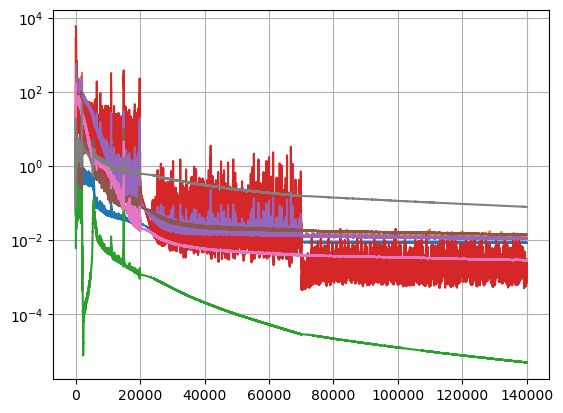

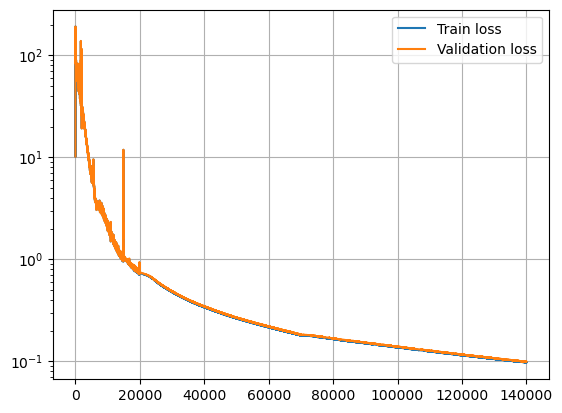

In [51]:
results = simulation(12, epochs=20000+1, epochs2=50000+1, epochs3=70000+1)

In [ ]:
'b_A': 0.001, 'b_B': 0.1, 'b_C': 1.0, 'V_A': 20.0,  'V_B': 100.0, 
'V_C': 100.0, 'K_AA': 5.0, 'K_AB': 5.0, 'K_AC': 10.0, 
'K_BA': 10.0, 'K_BC': 5.0, 'K_CB': 10.0, 'K_CC': 10.0

In [43]:
((L, n_val, D_A_val, D_B_val,
             b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
             K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
             K_CB_val, K_CC_val),
             params_ests,
             pinn1,
             optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
             w1, w2, w3, w4, w5, w6, w7, w8,
             losses,
             validation_loss) = results

In [ ]:
def create_epoch_callback(validation_loss):
    def epoch_callback1(epoch, loss_samples, index):            
        outputs = pinn1.net(ds_list_validation[:, 0, :])
        Ag = outputs[:, 0]
        Bg = outputs[:, 1]
        Cg = outputs[:, 2]

        A = ds_list_validation[:, 1, :][:, 0]
        B = ds_list_validation[:, 1, :][:, 1]
        C = ds_list_validation[:, 1, :][:, 2] 
        l2_res_A = np.mean((A - Ag)**2)
        l2_res_B = np.mean((B - Bg)**2)
        l2_res_C = np.mean((C - Cg)**2)    

        validation_loss[epoch, : ] = (l2_res_A, l2_res_B, l2_res_C)
        if epoch%1000==0:
            print(f"observation loss: {loss_samples[index, -3]}, {loss_samples[index, -2]}, {loss_samples[index, -1]}")
            print(f"total observation loss: {np.sum(loss_samples[index, -3:])}")
            print(f"validation loss: {l2_res_A}, {l2_res_B}, {l2_res_C}")
            print(f"total validation loss: {l2_res_A + l2_res_B + l2_res_C}")
    return epoch_callback1

epochs4 = 50000+1
params_est4 = np.zeros((epochs4, len(params_trainable1)))
validation_loss4 = np.zeros((epochs4, 3))
epoch_callback4 = create_epoch_callback(validation_loss4)



In [8]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

12 outputs_second_search/solution_10_10_103.npy
D_A:0.0100, D_B:1.0000, b_A:0.2910, mu_A:1.0000, V_A:15.8091, K_AA:4.9476, K_AB:4.2214, K_AC:38.7188, b_B:2.7616, mu_B:5.0000, V_B:93.3528, K_BA:10.9242, K_BC:43.3913, b_C:0.5972, mu_C:0.5000, V_C:1.1319, K_CB:2.9157, K_CC:2.3194


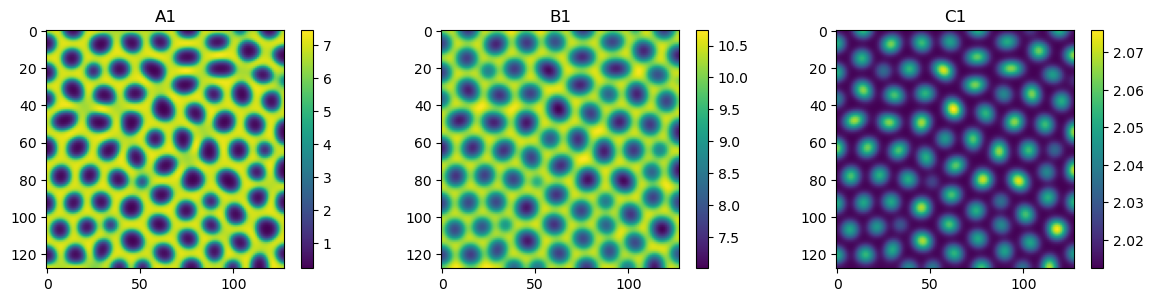

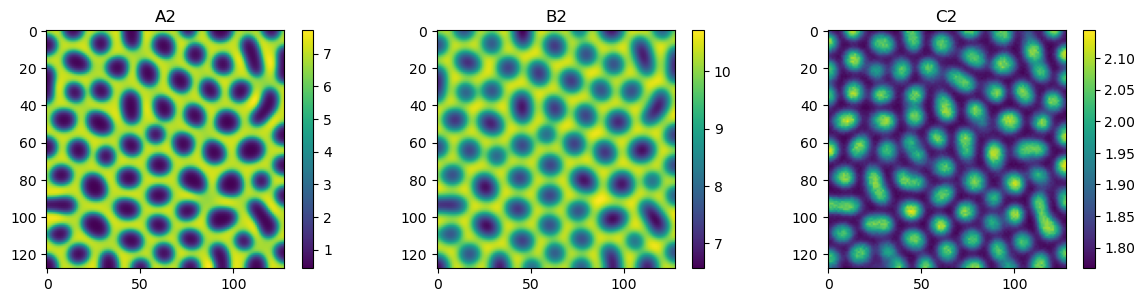

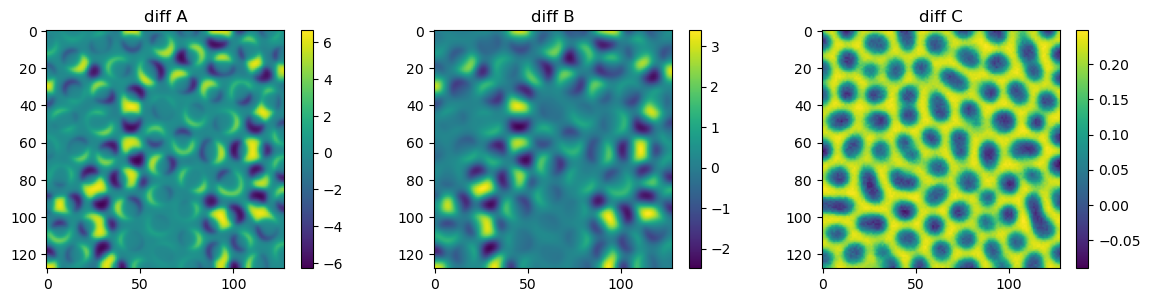

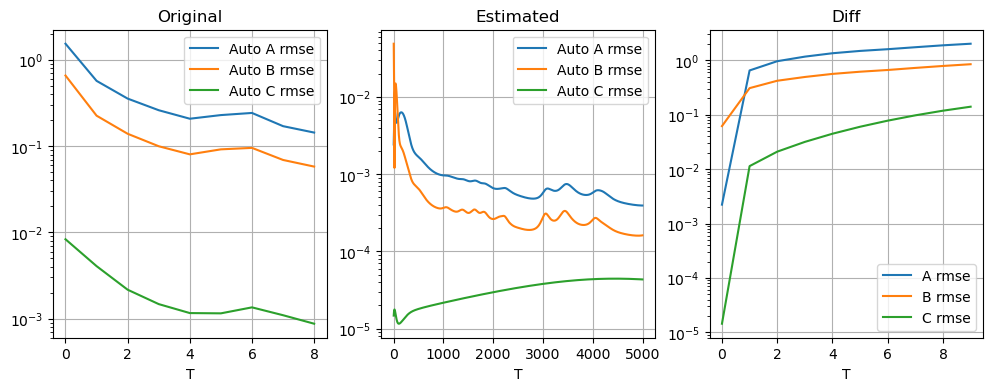

In [57]:
index = 12
path = subnet_df["path"].iloc[index]
print(index, path)
(params, res_1, k_max) = load_dataset(path)

n_val = params["n"]
mu_A_val, mu_B_val, mu_C_val = params["mu_A"], params["mu_B"], params["mu_C"]

b_A_val= 0.29097509384155273
b_B_val= 2.761601448059082
b_C_val= 0.5971809029579163
V_A_val= 15.809123992919922
V_B_val= 93.35276794433594
V_C_val= 1.1319358348846436
K_AA_val= 4.947638034820557
K_AB_val= 4.221375465393066
K_AC_val= 38.718849182128906
K_BA_val= 10.924220085144043
K_BC_val= 43.39127731323242
K_CB_val= 2.9156930446624756
K_CC_val= 2.3193721771240234


print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
      f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
      f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
      f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
      f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
      f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

A_init = res_1[0, 0, :]
B_init = res_1[0, 1, :]
C_init = res_1[0, 2, :]
res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 5000-1, 1)

A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_2[-1, 0, :]
B2 = res_2[-1, 1, :]
C2 = res_2[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_2[::500, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_2[::500, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_2[::500, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()